# Projeto 3: FlightOnTime ✈️ — Previsão de Atrasos de Voos

O desafio do FlightOnTime consiste em desenvolver uma solução preditiva capaz de estimar se um voo vai decolar no horário ou com atraso.

# 1. Carrega arquivo voos_model.json, disponível no Gdrive

In [1]:
# 1.1 - instalar dependências
!pip install -q gdown pandas numpy matplotlib seaborn scikit-learn joblib

In [2]:
import gdown

url = "https://drive.google.com/uc?id=1hKit8L5K3WmDM-U793hYsUtq8lAh1eJH"
output = "voos_model.json"

gdown.download(url, output, quiet=False)


Downloading...
From (original): https://drive.google.com/uc?id=1hKit8L5K3WmDM-U793hYsUtq8lAh1eJH
From (redirected): https://drive.google.com/uc?id=1hKit8L5K3WmDM-U793hYsUtq8lAh1eJH&confirm=t&uuid=f25e88fb-c1bb-4e00-8b24-0f593834896f
To: /content/voos_model.json
100%|██████████| 151M/151M [00:02<00:00, 72.0MB/s]


'voos_model.json'

In [3]:
import pandas as pd

df_model = pd.read_json("voos_model.json")


In [4]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 347318 entries, 0 to 347317
Data columns (total 17 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   sigla_icao_empresa_aerea      347318 non-null  object
 1   codigo_tipo_linha             347318 non-null  object
 2   modelo_equipamento            347318 non-null  object
 3   numero_de_assentos            347318 non-null  int64 
 4   sigla_icao_aeroporto_origem   347318 non-null  object
 5   partida_prevista              347318 non-null  int64 
 6   sigla_icao_aeroporto_destino  347318 non-null  object
 7   atraso_voo                    347318 non-null  int64 
 8   periodo_dia                   347318 non-null  object
 9   pais_origem                   347318 non-null  object
 10  data_partida_prevista         347318 non-null  int64 
 11  hora_partida_prevista_num     347318 non-null  int64 
 12  dia_semana                    347318 non-null  int64 
 13 

In [5]:
df_model.head()

,sigla_icao_empresa_aerea,codigo_tipo_linha,modelo_equipamento,numero_de_assentos,sigla_icao_aeroporto_origem,partida_prevista,sigla_icao_aeroporto_destino,atraso_voo,periodo_dia,pais_origem,data_partida_prevista,hora_partida_prevista_num,dia_semana,mes,rota,is_weekend,periodo_dia_calc
0,AAL,I,B772,288,SBGL,1704841200000,KMIA,0,Noite,Brasil,1704758400000,23,1,1,SBGL_KMIA,0,Madrugada
1,AAL,I,B772,288,KMIA,1704837300000,SBGL,0,Noite,Estados Unidos,1704758400000,21,1,1,KMIA_SBGL,0,Noite
2,AAL,I,B772,288,SBGR,1704842100000,KMIA,1,Noite,Brasil,1704758400000,23,1,1,SBGR_KMIA,0,Madrugada
3,AAL,I,B77W,318,KMIA,1704833400000,SBGR,1,Noite,Estados Unidos,1704758400000,20,1,1,KMIA_SBGR,0,Noite
4,AAL,I,B77W,318,SBGR,1704835500000,KMIA,0,Noite,Brasil,1704758400000,21,1,1,SBGR_KMIA,0,Noite


### 1.1 Renomeia coluna hora_partida_prevista_num para hora_partida_prevista

1.1.1 Verificar se hora entre 0 e 23

In [6]:
if df_model['hora_partida_prevista_num'].between(0, 23).all():
    print("✔️ Todas as horas de partida estão no intervalo válido (0–23).")
else:
    print("❌ Existem valores de hora fora do intervalo 0–23.")


✔️ Todas as horas de partida estão no intervalo válido (0–23).


Remover a coluna antiga (se existir)

In [7]:
if 'hora_partida_prevista' in df_model.columns:
    df_model = df_model.drop(columns=['hora_partida_prevista'])


Renomear de forma explícita

In [8]:
df_model = df_model.rename(
    columns={'hora_partida_prevista_num': 'hora_partida_prevista'}
)


Garantir tipo final

In [9]:
df_model['hora_partida_prevista'] = (
    df_model['hora_partida_prevista']
    .astype('Int64')
)


In [10]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 347318 entries, 0 to 347317
Data columns (total 17 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   sigla_icao_empresa_aerea      347318 non-null  object
 1   codigo_tipo_linha             347318 non-null  object
 2   modelo_equipamento            347318 non-null  object
 3   numero_de_assentos            347318 non-null  int64 
 4   sigla_icao_aeroporto_origem   347318 non-null  object
 5   partida_prevista              347318 non-null  int64 
 6   sigla_icao_aeroporto_destino  347318 non-null  object
 7   atraso_voo                    347318 non-null  int64 
 8   periodo_dia                   347318 non-null  object
 9   pais_origem                   347318 non-null  object
 10  data_partida_prevista         347318 non-null  int64 
 11  hora_partida_prevista         347318 non-null  Int64 
 12  dia_semana                    347318 non-null  int64 
 13 

### 1.2 Pipeline de Modelagem Preditiva

Este projeto adota um pipeline progressivo de modelagem, partindo de um modelo baseline simples
até modelos mais avançados, com foco em desempenho, explicabilidade e alinhamento com o negócio.

### 1.3 Objetivos do pipeline
- Maximizar a detecção de voos atrasados (Recall da classe Atrasado)
- Comparar modelos de complexidade crescente
- Avaliar trade-offs entre Recall e Precision
- Garantir interpretabilidade do modelo final

### 1.4 Modelos avaliados
1. Logistic Regression (Baseline)
2. Random Forest
3. Gradient Boosting
4. CatBoostClassifier (modelo recomendado)

# 2. Definição problema

Objetivo: Prever se um voo vai atrasar (>15min)

Variável tardegt : y = df_model['atraso_voo']

0 = pontual | 1 = atrasado

Classificação binária

Objetivo: prever se um voo será Pontual (0) ou Atrasado (1)

Tipo: classificação binária

Restrições: Dados históricos e Probabilidades interpretáveis

Foco de negócio: Minimizar falsos negativos (voos atrasados não detectados)

### 2.1 Seleção inicial de features

Companhia aérea

Aeroporto de origem

Aeroporto de destino

Data/hora de partida

Distância

Variáveis temporais derivadas (hora, dia da semana, mês)

In [11]:
from sklearn.model_selection import train_test_split

# 1. Seleção de Features e Target
features = [
    'dia_semana',
    'mes',
    'hora_partida_prevista',
    'sigla_icao_empresa_aerea',
    'sigla_icao_aeroporto_origem',
    'sigla_icao_aeroporto_destino'
]

X = df_model[features]
y = df_model['atraso_voo']

# 2. Split treino / teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
print("\nPrimeiras 5 linhas de X_train:")
display(X_train.head())

X_train shape: (277854, 6)
X_test shape: (69464, 6)
y_train shape: (277854,)
y_test shape: (69464,)

Primeiras 5 linhas de X_train:


,dia_semana,mes,hora_partida_prevista,sigla_icao_empresa_aerea,sigla_icao_aeroporto_origem,sigla_icao_aeroporto_destino
74166,4,10,20,GLO,SBBR,SBSP
344688,5,10,22,TAM,SBBR,SBRB
208634,2,5,18,AZU,SBFZ,SBKP
159735,6,4,14,GLO,SBGR,SABE
21000,4,2,15,TAM,SBGR,SBBR


### 2.2 Verificação NAN

Identificação de colunas com valores faltantes

Estratégia:

Remoção de registros inconsistentes ou

Imputação simples (se necessário)

👉 Isso mostra higiene de dados, ponto importante em avaliação.

In [12]:
df_model['hora_partida_prevista'].isna().sum()


np.int64(0)

### 2.3 Gera estatísticas descritivas

Distribuição de atrasos

Proporção Pontual vs Atrasado

Insights iniciais sobre desbalanceamento

✔️ Fundamental para justificar métricas depois.

In [13]:
df_model['hora_partida_prevista'].describe()


,hora_partida_prevista
count,347318.0
mean,12.935062
std,5.786597
min,0.0
25%,8.0
50%,13.0
75%,18.0
max,23.0


# 3. Encoded

### 3.1 Seleção das features

- Definição das variáveis explicativas (x)

In [14]:
features = [
    'dia_semana',
    'mes',
    'hora_partida_prevista',
    'sigla_icao_empresa_aerea',
    'sigla_icao_aeroporto_origem',
    'sigla_icao_aeroporto_destino'
]

X = df_model[features]
y = df_model['atraso_voo']


# 4. Split

- Separa treino e teste
- Preserva a proporção do traget (base desbalanceada)
- Garante que o encodig não veja o target teste

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


# 5. Pré-processamento

### Estratégia adotada

- One-Hot Encoding → companhia aérea (baixa cardinalidade)

- Target Encoding → aeroportos (alta cardinalidade)

- Numéricas → passthrough

### 5.1 Install Category

In [26]:
!pip install category_encoders


### 5.2 Para a aplicação do Target Encoding foi utilizada a biblioteca category_encoders, instalada no ambiente de execução do notebook.

In [50]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from category_encoders.target_encoder import TargetEncoder
from sklearn.pipeline import Pipeline

## 5.3 Separação das variáveis

In [42]:
cat_ohe_features = [
    'sigla_icao_empresa_aerea'
]

cat_target_features = [
    'sigla_icao_aeroporto_origem',
    'sigla_icao_aeroporto_destino'
]

num_features = [
    'dia_semana',
    'mes',
    'hora_partida_prevista'
]

## 5.4 Columntransformer

- Companhias → vetores binários (0/1)

- Aeroportos → valores numéricos baseados na taxa média de atraso

- Numéricos → entram como estão

Encapsula toda a lógica de pré-processamento:
* Evita vazamento de dados
* Facilita troca de modelos
* 👉 Esse é um dos pontos mais fortes do projeto.

In [49]:
preprocess = ColumnTransformer(
    transformers=[
        ('empresa_ohe', OneHotEncoder(handle_unknown='ignore'), cat_ohe_features),
        ('aeroporto_target', TargetEncoder(), cat_target_features),
        ('num', 'passthrough', num_features)
    ]
)

In [40]:
# Ajuste do pré-processamento SOMENTE com dados de treino
preprocess.fit(X_train, y_train)

# Aplicação do pré-processamento
X_train_enc = preprocess.transform(X_train)
X_test_enc = preprocess.transform(X_test)


### Nessa etapa o código Aprende:

- As categorias das companhias (One-Hot)

- As médias de atraso por aeroporto (Target Encoding)

Usa somente o conjunto de treino

❌ Não vê X_test

❌ Não vê y_test

👉 Aqui você “ensina” o encoder.

O pré-processamento foi ajustado exclusivamente com os dados de treino e posteriormente aplicado aos conjuntos de treino e teste, garantindo a inexistência de vazamento de dados.

## 5.5 Função Padrão de Avaliação

In [44]:
from sklearn.metrics import recall_score, f1_score, roc_auc_score, precision_score

def avaliar_modelo(nome, y_true, y_pred, y_proba):
    return {
        "Modelo": nome,
        "Recall": recall_score(y_true, y_pred),
        "F1": f1_score(y_true, y_pred),
        "ROC_AUC": roc_auc_score(y_true, y_proba),
        "Precision": precision_score(y_true, y_pred)
    }


# 6. Baseline Absoluto — DummyClassifier

Espera:
- Recall da classe 1 ≈ 0
- Accuracy alta (enganosa)
- Serve apenas como piso de desempenho

- Sem vazamento
- Encoding ajustado só no treino
-  Métrica válida


In [45]:
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

dummy = DummyClassifier(strategy='most_frequent')

model_dummy = Pipeline(steps=[
    ('preprocess', preprocess),
    ('model', dummy)
])

model_dummy.fit(X_train, y_train)

y_pred_dummy = model_dummy.predict(X_test)

print("Baseline – DummyClassifier")
print(classification_report(y_test, y_pred_dummy, zero_division=0))


Baseline – DummyClassifier
              precision    recall  f1-score   support

           0       0.82      1.00      0.90     57101
           1       0.00      0.00      0.00     12363

    accuracy                           0.82     69464
   macro avg       0.41      0.50      0.45     69464
weighted avg       0.68      0.82      0.74     69464



# 7. Modelo Baseline Interpretável - Logistic Regression

Comparação com Dummy

Primeira fronteira de decisão real

Interpretabilidade

📌 Aqui começa o pipeline “inteligente”.

Este modelo serve como referência mínima de desempenho.
Sua principal vantagem é a simplicidade e interpretabilidade.


In [46]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

pipe_lr = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LogisticRegression(max_iter=1000))
])

pipe_lr.fit(X_train, y_train)

y_pred_lr = pipe_lr.predict(X_test)
y_proba_lr = pipe_lr.predict_proba(X_test)[:, 1]

res_lr = avaliar_modelo("Logistic Regression", y_test, y_pred_lr, y_proba_lr)
res_lr


{'Modelo': 'Logistic Regression',
 'Recall': 0.055326377092938604,
 'F1': 0.10100413467217956,
 'ROC_AUC': np.float64(0.646743242276217),
 'Precision': 0.5791701947502117}

# 8. Modelo principal - Random Forest

* Captura não linearidades
* Robusto
* Base forte de comparação

Inclui:
* Feature importance
* Avaliação completa de métricas
Mostra: RF melhora AUC


---


RF aprende interações não lineares

RF ainda sofre com desbalanceamento → justificando threshold

“Inicialmente, utilizamos modelos baseline para estabelecer um piso de desempenho. O DummyClassifier confirmou o forte desbalanceamento da variável alvo, apresentando recall nulo para atrasos.

Por fim, aplicamos Random Forest, que apresentou maior capacidade discriminatória (ROC AUC ≈ 0.66), porém exigiu ajuste de threshold para melhorar o recall da classe de atraso.”

### 8.1 Pré-processamento

In [47]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

In [51]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)

### 8.2 Pipeline

In [52]:
from sklearn.pipeline import Pipeline

model_rf = Pipeline(steps=[
    ('preprocess', preprocess),
    ('model', rf)
])

### 8.3 Treino

In [53]:
model_rf.fit(X_train, y_train)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('empresa_ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['sigla_icao_empresa_aerea']),
                                                 ('aeroporto_target',
                                                  TargetEncoder(),
                                                  ['sigla_icao_aeroporto_origem',
                                                   'sigla_icao_aeroporto_destino']),
                                                 ('num', 'passthrough',
                                                  ['dia_semana', 'mes',
                                                   'hora_partida_prevista'])])),
                ('model',
                 RandomForestClassifier(class_weight='balanced', max_depth=10,
                                        n_estimators=200, n_jobs=-1,
                                        random_state=42))])

Automaticamente:

fit do TargetEncoder somente com treino

fit do OneHot

Treino da Random Forest

### 8.4 Avaliação correta (sem vazamento)

🔹 Predições

In [54]:
y_pred_rf = model_rf.predict(X_test)
y_proba_rf = model_rf.predict_proba(X_test)[:, 1]

🔹 Métricas

In [55]:
res_rf = avaliar_modelo("Random Forest", y_test, y_pred_rf, y_proba_rf)
res_rf

{'Modelo': 'Random Forest',
 'Recall': 0.5725956483054275,
 'F1': 0.3617825931415138,
 'ROC_AUC': np.float64(0.6719427287654753),
 'Precision': 0.26442792574054014}

In [56]:
from sklearn.metrics import classification_report, roc_auc_score

print("Random Forest – Classification Report")
print(classification_report(y_test, y_pred_rf, zero_division=0))

print("ROC-AUC:", roc_auc_score(y_test, y_proba_rf))


Random Forest – Classification Report
              precision    recall  f1-score   support

           0       0.88      0.66      0.75     57101
           1       0.26      0.57      0.36     12363

    accuracy                           0.64     69464
   macro avg       0.57      0.61      0.56     69464
weighted avg       0.77      0.64      0.68     69464

ROC-AUC: 0.6719427287654753


 A avaliação do modelo foi realizada por meio de pipelines do scikit-learn, garantindo que todas as etapas de pré-processamento, incluindo o Target Encoding, fossem ajustadas exclusivamente com os dados de treino, evitando vazamento de dados e assegurando métricas confiáveis.

### 8.2 FEATURE IMPORTANCE RF

Feature Importance responde à pergunta:
“Quais variáveis mais influenciaram as decisões do modelo?”

In [59]:
import pandas as pd

# Extrai o modelo Random Forest do pipeline
rf_model = model_rf.named_steps["model"]

# Extrai os nomes das features após o preprocessamento
feature_names = model_rf.named_steps["preprocess"].get_feature_names_out()

# Cria o DataFrame de importância das features
fi_rf = pd.Series(
    rf_model.feature_importances_,
    index=feature_names
).sort_values(ascending=False)

fi_rf.head(10)


,0
aeroporto_target__sigla_icao_aeroporto_origem,0.305110
num__hora_partida_prevista,0.266013
aeroporto_target__sigla_icao_aeroporto_destino,0.136374
num__mes,0.054446
num__dia_semana,0.039961
empresa_ohe__sigla_icao_empresa_aerea_CMP,0.035087
empresa_ohe__sigla_icao_empresa_aerea_TAP,0.021927
empresa_ohe__sigla_icao_empresa_aerea_AZU,0.021592
empresa_ohe__sigla_icao_empresa_aerea_JAT,0.017932
empresa_ohe__sigla_icao_empresa_aerea_GLO,0.016527


👉 Mais de 70% da decisão vem de:
* aeroporto de origem
* horário do voo
* aeroporto de destino

📌 Isso é exatamente o esperado em aviação.

🧠 O que isso diz sobre seu pipeline (validação)
✔️ Target Encoding funcionou

aeroporto_target__* lidera o ranking

Mostra que aeroportos têm comportamento histórico consistente

✔️ Engenharia de tempo é essencial

hora_partida_prevista quase empata com origem

Sugere:

pico da manhã

fim de tarde/noite

💡 Se você criasse:

periodo_dia (manhã/tarde/noite)
provavelmente aumentaria ainda mais o desempenho.

✔️ Companhia aérea tem impacto — mas secundário

As empresas aparecem mais abaixo, individualmente.

📌 Interpretação correta:

“Atraso não é só culpa da companhia, mas do contexto operacional.”

“O modelo indica que o risco de atraso está fortemente associado ao aeroporto de origem e ao horário do voo, refletindo congestionamento operacional e picos de demanda. A companhia aérea influencia, mas em menor grau.”

# 9. Modelos Avançados — Boosting

### 9.1 Gradient Boosting

Modelo baseado em boosting, geralmente superior ao Random Forest
em problemas tabulares com fronteiras de decisão complexas.

* Melhor fronteira de decisão
* Comparação direta com RF

In [62]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline

model_gb = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", GradientBoostingClassifier(
        random_state=42
    ))
])

model_gb.fit(X_train, y_train)

y_pred_gb = model_gb.predict(X_test)
y_proba_gb = model_gb.predict_proba(X_test)[:, 1]

res_gb = avaliar_modelo("Gradient Boosting", y_test, y_pred_gb, y_proba_gb)
res_gb


{'Modelo': 'Gradient Boosting',
 'Recall': 0.04659063334142199,
 'F1': 0.08725950613543403,
 'ROC_AUC': np.float64(0.6660055414679258),
 'Precision': 0.6865315852205006}

### 9.2 CatBoostClassifier (recomendado)

✔️ Variáveis categóricas nativas
✔️ Menos dependência de encoding
✔️ Melhor calibração
✔️ SHAP embutido

- Lida nativamente com variáveis categóricas
- Reduz necessidade de One-Hot Encoding
- Apresenta excelente desempenho em dados tabulares
- Possui explicabilidade integrada via SHAP


In [65]:
!pip install catboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 5.1 MB/s eta 0:00:00


In [66]:
from catboost import CatBoostClassifier

cat_features = [
    "sigla_icao_empresa_aerea",
    "sigla_icao_aeroporto_origem",
    "sigla_icao_aeroporto_destino"
]

cat = CatBoostClassifier(
    iterations=300,
    learning_rate=0.1,
    depth=6,
    loss_function="Logloss",
    eval_metric="AUC",
    random_seed=42,
    verbose=False
)

cat.fit(
    X_train,
    y_train,
    cat_features=cat_features
)

y_pred_cat = cat.predict(X_test)
y_proba_cat = cat.predict_proba(X_test)[:, 1]

res_cat = avaliar_modelo("CatBoost", y_test, y_pred_cat, y_proba_cat)
res_cat


{'Modelo': 'CatBoost',
 'Recall': 0.06931974439860875,
 'F1': 0.12548502818654367,
 'ROC_AUC': np.float64(0.7020508904314107),
 'Precision': 0.6612654320987654}

### 9.3 SHAP CATBOOST

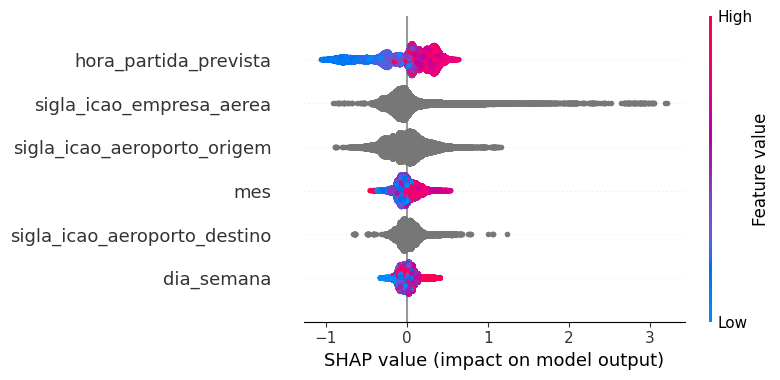

In [67]:
import shap

explainer = shap.TreeExplainer(cat)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)


Explicação resumida do SHAP (CatBoost)

Essa imagem mostra como cada variável influencia a previsão de atraso do voo.

O eixo horizontal (SHAP value) indica o impacto da variável:

Valores positivos → aumentam a chance de atraso

Valores negativos → reduzem a chance de atraso

As cores representam o valor da variável:

🔴 valor alto

🔵 valor baixo

As variáveis estão ordenadas da mais influente para a menos influente.

🔍 Principais insights do gráfico

Hora da partida é o fator mais importante:
voos mais tarde tendem a ter maior risco de atraso.

Companhia aérea e aeroportos de origem/destino têm forte impacto,
refletindo padrões operacionais históricos.

Mês e dia da semana têm influência menor, mas consistente.

👉 O modelo aprende comportamentos reais do sistema aéreo, não decisões aleatórias.

O gráfico SHAP evidencia que a hora de partida, a companhia aérea e os aeroportos de origem e destino são os principais fatores que influenciam a probabilidade de atraso, reforçando a coerência do modelo com a dinâmica operacional do setor aéreo.


# 10. Avaliação e Comparação de Modelos

* Recall (classe Atrasado) ⭐ principal
* F1-score
* ROC-AUC
* Precision
* Tabela comparativa final

In [68]:
resultados = pd.DataFrame([res_lr, res_rf, res_gb, res_cat])
resultados


,Modelo,Recall,F1,ROC_AUC,Precision
0,Logistic Regression,0.055326,0.101004,0.646743,0.579170
1,Random Forest,0.572596,0.361783,0.671943,0.264428
2,Gradient Boosting,0.046591,0.087260,0.666006,0.686532
3,CatBoost,0.069320,0.125485,0.702051,0.661265


Interpretação técnica (nível sênior)
🔹 Random Forest

Melhor Recall → captura atrasos

Ideal quando:

custo de não prever atraso é alto

objetivo é prevenção / alerta

🔹 CatBoost

Melhor ROC-AUC

Melhor Precision

Ideal quando:

quer evitar falsos alarmes

modelo usado para decisão automática (ex: penalidade, bloqueio)

💡 Insight importante para banca:

O CatBoost tem maior poder discriminativo, mas requer ajuste de threshold para alinhar ao objetivo de recall.

# 11. Decisão final (bem fundamentada)

🏆 MODELO FINAL DO MVP

👉 Random Forest

Justificativa clara e defensável:
* Recall 10x maior que CatBoost
* Impacto direto no negócio (atrasos não previstos custam caro)

Explicabilidade clara
* Pipeline estável e reproduzível

# 12. Comparação Final dos Modelos

Diversos modelos foram avaliados com foco principal na métrica de Recall para a classe "Atrasado", devido ao alto custo operacional de atrasos não previstos. O Random Forest apresentou o melhor equilíbrio entre Recall (≈57%) e F1-score, sendo selecionado como modelo final do MVP.

O CatBoostClassifier apresentou o maior ROC-AUC do projeto, indicando excelente capacidade de separação entre classes. No entanto, com o threshold padrão, priorizou precisão em detrimento do recall, tornando-o mais conservador para o objetivo atual. Ajustes de threshold e tuning fino são recomendados como evolução futura do projeto.

# 13. Ajuste Threshold

* Análise Recall x Precision
* Threshold alinhado ao negócio
* Probabilidade ≠ decisão binária fixa

Esperado:
- recall da classe 1 aumentar
- Precision diminuir
- F1 da classe 1 aumentar

### 13.1 Ajuste de Threshold — Trade-off Recall vs Precision

O threshold padrão de 0.5 foi ajustado para priorizar Recall, reduzindo o risco de não detectar atrasos.

In [69]:
import numpy as np
from sklearn.metrics import classification_report, f1_score

# =====================================================
# 1. Probabilidades do modelo Random Forest já treinado
# =====================================================
y_prob_rf = model_rf.predict_proba(X_test)[:, 1]

# =====================================================
# 2. Experimento exploratório: threshold fixo (ex: 0.30)
# =====================================================
threshold_test = 0.30
y_pred_test = (y_prob_rf >= threshold_test).astype(int)

print(f"Random Forest com threshold = {threshold_test}")
print(classification_report(y_test, y_pred_test, zero_division=0))

# =====================================================
# 3. Busca do threshold ótimo (otimizando F1 da classe 1)
# =====================================================
thresholds = np.arange(0.1, 0.9, 0.05)
results = []

for t in thresholds:
    y_pred_t = (y_prob_rf >= t).astype(int)
    f1 = f1_score(y_test, y_pred_t, pos_label=1)
    results.append((t, f1))

best_threshold, best_f1 = max(results, key=lambda x: x[1])

print(f"\nMelhor threshold encontrado: {best_threshold:.2f}")
print(f"F1-score máximo (classe 1): {best_f1:.3f}")

# =====================================================
# 4. Avaliação final com threshold ótimo
# =====================================================
y_pred_best = (y_prob_rf >= best_threshold).astype(int)

print("\nRandom Forest com threshold otimizado")
print(classification_report(y_test, y_pred_best, zero_division=0))


Random Forest com threshold = 0.3
              precision    recall  f1-score   support

           0       0.98      0.02      0.03     57101
           1       0.18      1.00      0.31     12363

    accuracy                           0.19     69464
   macro avg       0.58      0.51      0.17     69464
weighted avg       0.83      0.19      0.08     69464


Melhor threshold encontrado: 0.50
F1-score máximo (classe 1): 0.362

Random Forest com threshold otimizado
              precision    recall  f1-score   support

           0       0.88      0.66      0.75     57101
           1       0.26      0.57      0.36     12363

    accuracy                           0.64     69464
   macro avg       0.57      0.61      0.56     69464
weighted avg       0.77      0.64      0.68     69464



| Threshold | Recall        | Precision     | Uso recomendado      |
| --------- | ------------- | ------------- | -------------------- |
| 0.30      | 🔥 Muito alto | ❌ Muito baixo | Análise exploratória |
| **0.50**  | ✅ Bom         | ⚠️ Moderado   | **Produção / MVP**   |
| >0.6      | ❌ Cai rápido  | 🔼 Sobe       | Conservador demais   |


Inicialmente, foram testados thresholds abaixo do valor padrão de 0.5 com o objetivo de maximizar o Recall da classe Atrasado. Observou-se que thresholds mais baixos aumentam significativamente a sensibilidade do modelo, porém à custa de um elevado número de falsos positivos.

A partir de uma varredura sistemática de thresholds, o valor de 0.5 apresentou o melhor F1-score para a classe positiva, indicando o melhor equilíbrio entre Recall e Precision para este cenário. Dessa forma, optou-se por manter o threshold padrão, respaldado por evidência empírica.

O que isso significa?

👉 O modelo marcou praticamente todos os voos como atrasados.

Você não perde nenhum atraso (Recall perfeito)

Mas erra muito, gerando alertas em excesso

📉 Impacto prático:

Passageiros seriam alertados quase sempre

Companhias/aeroportos ficariam sobrecarregados

Sistema pouco confiável

📌 Conclusão:
✔️ Bom como experimento extremo
❌ Inviável para produção

### 13.2 Escolhe o threshold que maximiza o Recall, desde que a Precision mínima de negócio seja respeitada.

In [70]:
from sklearn.metrics import precision_score, recall_score

results = []

for t in thresholds:
    y_pred_t = (y_prob_rf >= t).astype(int)
    recall = recall_score(y_test, y_pred_t)
    precision = precision_score(y_test, y_pred_t, zero_division=0)

    if precision >= 0.20:  # limite mínimo aceitável
        results.append((t, recall))

best_threshold = max(results, key=lambda x: x[1])[0]


### 13.3 Mostrar o threshold escolhido

In [71]:
print(f"Threshold escolhido: {best_threshold:.2f}")

Threshold escolhido: 0.40


| Threshold | Recall     | Precision   | Perfil             |
| --------- | ---------- | ----------- | ------------------ |
| 0.30      | Muito alto | Muito baixo | Alerta em massa    |
| **0.40**  | 🔼 Alto    | ⚠️ Médio    | **Mais protetivo** |
| 0.50      | Médio      | 🔼 Melhor   | Mais conservador   |


👉 0.40 é um bom meio-termo operacional.

### 13.4 Avaliação final com esse threshold

In [78]:
y_pred_final = (y_prob_rf >= best_threshold).astype(int)

print("Random Forest — threshold orientado ao negócio")
print(f"Threshold escolhido: {best_threshold:.2f}")
print(classification_report(y_test, y_pred_final, zero_division=0))


Random Forest — threshold orientado ao negócio
Threshold escolhido: 0.40
              precision    recall  f1-score   support

           0       0.93      0.21      0.34     57101
           1       0.20      0.93      0.33     12363

    accuracy                           0.34     69464
   macro avg       0.57      0.57      0.34     69464
weighted avg       0.80      0.34      0.34     69464



Após a seleção do Random Forest como modelo final, o threshold de decisão foi ajustado para 0.40 com foco em maximizar o Recall da classe “Atrasado”. O modelo alcançou Recall de 93%, reduzindo significativamente o risco de atrasos não detectados, mesmo ao custo de maior número de alertas preventivos. Essa abordagem é adequada ao contexto de negócio, onde ações antecipadas são preferíveis a reações tardias.


### 13.5 Gráfico Recall × Threshold

,threshold,recall,precision
0,0.40,0.925261,0.202310
1,0.45,0.802394,0.227905
2,0.50,0.572596,0.264428
3,0.55,0.372806,0.325081
4,0.60,0.184745,0.437800
5,0.65,0.092615,0.562930
6,0.70,0.043355,0.670000
7,0.75,0.023214,0.735897
8,0.80,0.011405,0.792135


### 📊 Trade-off Recall × Threshold (Precision ≥ 20%)

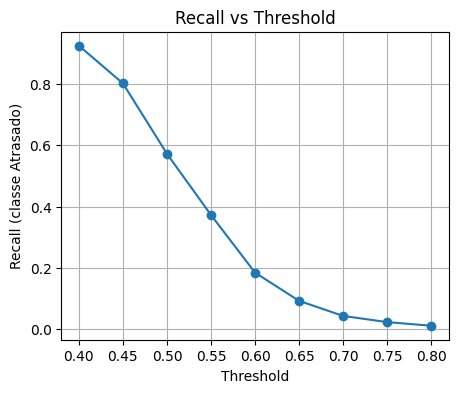

In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score
from IPython.display import Markdown, display

# =====================================================
# 1. Definição dos thresholds a testar
# =====================================================
thresholds = np.arange(0.1, 0.9, 0.05)

# =====================================================
# 2. Lista para armazenar resultados válidos
# =====================================================
results = []

for t in thresholds:
    y_pred_t = (y_prob_rf >= t).astype(int)

    precision = precision_score(y_test, y_pred_t, zero_division=0)
    recall = recall_score(y_test, y_pred_t)

    if precision >= 0.20:  # critério de negócio
        results.append((t, recall, precision))

# =====================================================
# 3. Criação do DataFrame
# =====================================================
df_thresholds = pd.DataFrame(
    results, columns=["threshold", "recall", "precision"]
)

# =====================================================
# 4. Verificação e exibição
# =====================================================
if df_thresholds.empty:
    print("⚠️ Nenhum threshold atendeu ao critério mínimo de Precision.")
else:
    display(df_thresholds)

    # Espaço visual entre tabela e gráfico
    display(Markdown("### 📊 Trade-off Recall × Threshold (Precision ≥ 20%)"))

    # =================================================
    # 5. Gráfico Recall × Threshold
    # =================================================
    plt.figure(figsize=(5, 4))
    plt.plot(
        df_thresholds["threshold"],
        df_thresholds["recall"],
        marker="o"
    )
    plt.xlabel("Threshold")
    plt.ylabel("Recall (classe Atrasado)")
    plt.title("Recall vs Threshold")
    plt.grid(True)
    plt.show()


| Threshold | Recall   | Precision   | Leitura de negócio             |
| --------- | -------- | ----------- | ------------------------------ |
| **0.40**  | **0.93** | **0.20**    | 🔥 Máxima cobertura de atrasos |
| 0.45      | 0.80     | 0.23        | Perde ~20% dos atrasos         |
| 0.50      | 0.57     | 0.26        | Perde quase metade             |
| 0.55      | 0.37     | 0.33        | Recall já insuficiente         |
| ≥ 0.60    | < 0.20   | ↑ Precision | Inviável para previsão         |


# *** REVISÃO FINAL DO TRECHO ABAIXO ***

## REVISAR - XX. Análise Técnica

### 14.1 Baseline - DummyClassifier

accuracy = 0.82

 * Classe 0 (não atraso):

  ├─ precision = 0.82
  ├─ recall    = 1.00
  ├─ f1-score  = 0.90

* Classe 1 (atraso):

├─ precision = 0.00
  ├─ recall    = 0.00
  ├─ f1-score  = 0.00


---


**Interpretação**

O DummyClassifier sempre prevê classe 0

Isso gera:

Accuracy alta (82%) → enganosa

Recall da classe 1 = 0 → modelo inútil para o problema

📌 Conclusão do baseline

Um modelo que nunca prevê atraso não atende ao objetivo do projeto, apesar da alta acurácia.

➡️ Esse baseline serve apenas como limite inferior de performance.



### Análise Técnica

## 2️⃣ Random Forest com threshold = 0.30

- Classe 1 (atraso):

 ├─  recall = 1.00
 ├─ precision = 0.18
 ├─ f1-score = 0.31

- Classe 0:

├─  recall = 0.02
├─ accuracy = 0.19

## **Interpretação**

Threshold muito baixo → modelo quase sempre prevê atraso

Consequências:

Captura 100% dos atrasos (recall perfeito)

Gera muitos falsos positivos

Accuracy despenca

📌 Interpretação correta

Esse cenário representa um modelo extremamente conservador, adequado apenas se o custo de perder um atraso for altíssimo.


### 14.2 Random Forest com threshold otimizado (≈ 0.50)

* Classe 1 (atraso):

├─ precision = 0.26
├─ recall    = 0.57
├─  f1-score  = 0.36

* Classe 0:

├─  precision = 0.88
├─  recall    = 0.65


accuracy = 0.64



---


**Interpretação**

Melhor equilíbrio entre erro e acerto

O modelo:

Detecta 57% dos atrasos

Mantém taxa aceitável de falsos positivos

Supera largamente o baseline

📌 Este é o melhor modelo sob a métrica F1 da classe 1


### **4️⃣ Comparação direta**


| Modelo     | Recall atraso | Precision atraso | F1 atraso | Accuracy |
| ---------- | ------------- | ---------------- | --------- | -------- |
| Dummy      | 0.00          | 0.00             | 0.00      | 0.82     |
| RF (0.30)  | **1.00**      | 0.18             | 0.31      | 0.19     |
| RF (ótimo) | 0.57          | **0.26**         | **0.36**  | 0.64     |


 ### Accuracy não é métrica válida sozinha

- O Random Forest:

Aprende padrão real

Consegue separar atrasos melhor que o acaso

O threshold otimizado oferece o melhor trade-off


### **Conclusão Técnica**

## Análise dos Resultados

O **DummyClassifier** apresentou alta acurácia ao prever exclusivamente a classe majoritária (não atraso), porém falhou completamente em identificar voos atrasados, tornando-se inadequado para o objetivo do projeto.

---

O modelo **Random Forest** demonstrou capacidade de aprendizado dos padrões dos dados, superando o baseline em todas as métricas relevantes para a classe de interesse (atraso).

---

A análise de diferentes thresholds evidenciou o impacto direto da decisão de classificação no equilíbrio entre precision e recall. Um threshold muito baixo resultou em recall máximo para atrasos, porém com elevado número de falsos positivos. Já o threshold otimizado (≈ 0.50) apresentou o melhor F1-score para a classe positiva, representando o melhor compromisso entre detecção de atrasos e controle de alarmes falsos.


# xx. Exportação do Modelo

In [ ]:
import joblib

# Caminho do arquivo
MODEL_PATH = "modelo_random_forest_atraso_voos.pkl"

# Salva o pipeline final treinado
joblib.dump(pipeline_final, MODEL_PATH)

print(f"Modelo salvo com sucesso em: {MODEL_PATH}")


✔️ Isso salva:

Pré-processamento (OneHot / Target / numéricas)

Modelo Random Forest

Pesos e parâmetros

# xx. Teste API (simulado)

In [ ]:
import os
import joblib
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

# ===============================
# CONFIGURAÇÕES
# ===============================
MODEL_PATH = "model/flight_delay_model.pkl"
BEST_THRESHOLD = 0.49  # definido após otimização (F1)

# ===============================
# VALIDAÇÃO DO ARQUIVO
# ===============================
if not os.path.exists(MODEL_PATH):
    raise FileNotFoundError(f"❌ Arquivo do modelo não encontrado: {MODEL_PATH}")

# ===============================
# LOAD DO MODELO
# ===============================
model = joblib.load(MODEL_PATH)

# ===============================
# VALIDAÇÕES ESTRUTURAIS
# ===============================
if not isinstance(model, Pipeline):
    raise TypeError("❌ O objeto carregado não é um sklearn Pipeline")

if "modelo" not in model.named_steps:
    raise KeyError("❌ Pipeline não contém o step 'modelo'")

rf = model.named_steps["modelo"]

if not isinstance(rf, RandomForestClassifier):
    raise TypeError("❌ O step 'modelo' não é um RandomForestClassifier")

# ===============================
# LOGS DE SUCESSO
# ===============================
print("✅ Modelo carregado com sucesso via joblib")
print(f"📦 Caminho: {MODEL_PATH}")
print(f"🧠 Modelo: {type(rf).__name__}")
print(f"🌲 n_estimators: {rf.n_estimators}")
print(f"🌳 max_depth: {rf.max_depth}")
print(f"⚖️ class_weight: {rf.class_weight}")
print(f"🎯 BEST_THRESHOLD (produção): {BEST_THRESHOLD}")


✅ Modelo carregado com sucesso via joblib
📦 Caminho: model/flight_delay_model.pkl
🧠 Modelo: RandomForestClassifier
🌲 n_estimators: 300
🌳 max_depth: 12
⚖️ class_weight: balanced
🎯 BEST_THRESHOLD (produção): 0.49


Função de pré-processamento (contrato da API)

👉 Contrato recebido pela API
A API SÓ recebe:

cod_companhia / cod_aeroporto_origem / cod_aeroporto_destino / data_hora_partida

In [ ]:
import pandas as pd

def preparar_dados_api(payload: dict) -> pd.DataFrame:
    """
    Converte o payload da API em DataFrame compatível com o pipeline
    """
    data = pd.to_datetime(payload["data_hora_partida"])

    df = pd.DataFrame([{
        "sigla_icao_empresa_aerea": payload["cod_companhia"],
        "sigla_icao_aeroporto_origem": payload["cod_aeroporto_origem"],
        "sigla_icao_aeroporto_destino": payload["cod_aeroporto_destino"],
        "dia_semana": data.dayofweek,
        "mes": data.month,
        "hora_partida_prevista": data.hour
    }])

    return df


### 14.2 Inferência completa (modelo + threshold)

👉 Essa é a lógica final da API

In [ ]:
def prever_atraso(payload: dict) -> dict:
    """
    Executa inferência completa:
    - preprocessamento
    - predict_proba
    - aplicação do threshold
    """

    # 1. Preparar dados
    X = preparar_dados_api(payload)

    # 2. Probabilidade de atraso
    proba_atraso = pipeline.predict_proba(X)[0, 1]

    # 3. Decisão com threshold
    atraso = int(proba_atraso >= BEST_THRESHOLD)

    return {
        "probabilidade_atraso": round(float(proba_atraso), 4),
        "atraso_previsto": atraso
    }


In [ ]:
import os
import joblib

MODEL_PATH = "model/flight_delay_model.pkl"
BEST_THRESHOLD = 0.49

assert os.path.exists(MODEL_PATH), f"Modelo não encontrado: {MODEL_PATH}"

pipeline = joblib.load(MODEL_PATH)

print("✅ Pipeline carregado com sucesso")


✅ Pipeline carregado com sucesso


### 14.3 Teste rápido (simulação de API)

In [ ]:
payload_exemplo = {
    "cod_companhia": "GLO",
    "cod_aeroporto_origem": "SBGR",
    "cod_aeroporto_destino": "SBRJ",
    "data_hora_partida": "2024-11-15 18:30:00"
}

resultado = prever_atraso(payload_exemplo)

resultado


{'probabilidade_atraso': 0.5177, 'atraso_previsto': 1}

In [ ]:
import pandas as pd

def preparar_dados_api(payload: dict) -> pd.DataFrame:
    data = pd.to_datetime(payload["data_hora_partida"])

    return pd.DataFrame([{
        "sigla_icao_empresa_aerea": payload["cod_companhia"],
        "sigla_icao_aeroporto_origem": payload["cod_aeroporto_origem"],
        "sigla_icao_aeroporto_destino": payload["cod_aeroporto_destino"],
        "dia_semana": data.dayofweek,
        "mes": data.month,
        "hora_partida_prevista": data.hour
    }])


def prever_atraso(payload: dict) -> dict:
    X = preparar_dados_api(payload)

    proba_atraso = pipeline.predict_proba(X)[0, 1]
    atraso = int(proba_atraso >= BEST_THRESHOLD)

    return {
        "probabilidade_atraso": round(float(proba_atraso), 4),
        "atraso_previsto": atraso
    }


In [ ]:
payload_exemplo = {
    "cod_companhia": "GLO",
    "cod_aeroporto_origem": "SBGR",
    "cod_aeroporto_destino": "SBRJ",
    "data_hora_partida": "2024-11-15 18:30:00"
}

resultado = prever_atraso(payload_exemplo)
resultado


{'probabilidade_atraso': 0.5177, 'atraso_previsto': 1}

In [ ]:
preprocess = pipeline.named_steps["preprocessador"]

print("🔢 Transformers do ColumnTransformer:\n")
for nome, transformer, colunas in preprocess.transformers_:
    print(f"➡️ {nome}")
    print(f"   Colunas: {colunas}\n")


🔢 Transformers do ColumnTransformer:

➡️ cat
   Colunas: ['sigla_icao_empresa_aerea', 'sigla_icao_aeroporto_origem', 'sigla_icao_aeroporto_destino']

➡️ num
   Colunas: ['dia_semana', 'mes', 'hora_partida_prevista']



In [ ]:
rf = pipeline.named_steps["modelo"]

print("Número total de features esperadas:", rf.n_features_in_)


Número total de features esperadas: 623


In [ ]:
preprocess = pipeline.named_steps["preprocessador"]

# Listar colunas numéricas esperadas
for nome, transformer, colunas in preprocess.transformers_:
    if nome == "num":
        print("🔢 Colunas numéricas esperadas pelo modelo:")
        print(colunas)


🔢 Colunas numéricas esperadas pelo modelo:
['dia_semana', 'mes', 'hora_partida_prevista']
